# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 14            
model_seed = 4           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import SVHN_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# Optional: you can keep hidden_dims or increase due to higher input size
hidden_dims = [512, 256]  # Suggested for SVHN, but your choice

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics (unchanged)
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 2.3367 | Test Loss 2.5366 | accs Train 0.0833 Test 0.1774


Epoch 100/2000: Train Loss 0.0002 | Test Loss 10.5173 | accs Train 1.0000 Test 0.1459


Epoch 200/2000: Train Loss 0.0001 | Test Loss 10.7273 | accs Train 1.0000 Test 0.1456


Epoch 300/2000: Train Loss 0.0001 | Test Loss 10.9162 | accs Train 1.0000 Test 0.1457


Epoch 400/2000: Train Loss 0.0001 | Test Loss 11.0825 | accs Train 1.0000 Test 0.1452


Epoch 500/2000: Train Loss 0.0000 | Test Loss 11.2278 | accs Train 1.0000 Test 0.1446


Epoch 600/2000: Train Loss 0.0000 | Test Loss 11.3625 | accs Train 1.0000 Test 0.1446


Epoch 700/2000: Train Loss 0.0000 | Test Loss 11.4959 | accs Train 1.0000 Test 0.1449


Epoch 800/2000: Train Loss 0.0000 | Test Loss 11.6676 | accs Train 1.0000 Test 0.1457


Epoch 900/2000: Train Loss 0.0000 | Test Loss 11.7680 | accs Train 1.0000 Test 0.1457


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 11.8643 | accs Train 1.0000 Test 0.1456


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 11.9575 | accs Train 1.0000 Test 0.1459


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 12.0482 | accs Train 1.0000 Test 0.1459


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 12.1428 | accs Train 1.0000 Test 0.1456


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 12.2272 | accs Train 1.0000 Test 0.1452


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 12.3080 | accs Train 1.0000 Test 0.1451


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 12.3829 | accs Train 1.0000 Test 0.1452


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 12.4518 | accs Train 1.0000 Test 0.1452


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 12.5179 | accs Train 1.0000 Test 0.1452


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 12.5822 | accs Train 1.0000 Test 0.1454


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 12.6432 | accs Train 1.0000 Test 0.1452
Completed training with 0 additional samples of data
Epoch 1/2000: Train Loss 2.3218 | Test Loss 2.5114 | accs Train 0.0917 Test 0.1964


Epoch 100/2000: Train Loss 0.0047 | Test Loss 4.2319 | accs Train 1.0000 Test 0.4118


Epoch 200/2000: Train Loss 0.0013 | Test Loss 4.7255 | accs Train 1.0000 Test 0.4138


Epoch 300/2000: Train Loss 0.0006 | Test Loss 5.0141 | accs Train 1.0000 Test 0.4156


Epoch 400/2000: Train Loss 0.0004 | Test Loss 5.2272 | accs Train 1.0000 Test 0.4153


Epoch 500/2000: Train Loss 0.0003 | Test Loss 5.3869 | accs Train 1.0000 Test 0.4158


Epoch 600/2000: Train Loss 0.0002 | Test Loss 5.5232 | accs Train 1.0000 Test 0.4161


Epoch 700/2000: Train Loss 0.0001 | Test Loss 5.6383 | accs Train 1.0000 Test 0.4159


Epoch 800/2000: Train Loss 0.0001 | Test Loss 5.7365 | accs Train 1.0000 Test 0.4158


Epoch 900/2000: Train Loss 0.0001 | Test Loss 5.8220 | accs Train 1.0000 Test 0.4161


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 5.9000 | accs Train 1.0000 Test 0.4159


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 5.9714 | accs Train 1.0000 Test 0.4159


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 6.0362 | accs Train 1.0000 Test 0.4158


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 6.0954 | accs Train 1.0000 Test 0.4155


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 6.1499 | accs Train 1.0000 Test 0.4155


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 6.2009 | accs Train 1.0000 Test 0.4158


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 6.2493 | accs Train 1.0000 Test 0.4159


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 6.2963 | accs Train 1.0000 Test 0.4155


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 6.3406 | accs Train 1.0000 Test 0.4158


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 6.3829 | accs Train 1.0000 Test 0.4163


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 6.4231 | accs Train 1.0000 Test 0.4164
Completed training with 540 additional samples of data
Epoch 1/2000: Train Loss 2.3202 | Test Loss 2.4404 | accs Train 0.0935 Test 0.1959


Epoch 100/2000: Train Loss 0.1157 | Test Loss 2.1853 | accs Train 0.9845 Test 0.5697


Epoch 200/2000: Train Loss 0.0080 | Test Loss 2.7462 | accs Train 1.0000 Test 0.5766


Epoch 300/2000: Train Loss 0.0032 | Test Loss 3.0394 | accs Train 1.0000 Test 0.5767


Epoch 400/2000: Train Loss 0.0017 | Test Loss 3.2371 | accs Train 1.0000 Test 0.5763


Epoch 500/2000: Train Loss 0.0011 | Test Loss 3.3894 | accs Train 1.0000 Test 0.5764


Epoch 600/2000: Train Loss 0.0008 | Test Loss 3.5083 | accs Train 1.0000 Test 0.5766


Epoch 700/2000: Train Loss 0.0006 | Test Loss 3.6076 | accs Train 1.0000 Test 0.5771


Epoch 800/2000: Train Loss 0.0004 | Test Loss 3.6934 | accs Train 1.0000 Test 0.5771


Epoch 900/2000: Train Loss 0.0003 | Test Loss 3.7701 | accs Train 1.0000 Test 0.5775


Epoch 1000/2000: Train Loss 0.0003 | Test Loss 3.8382 | accs Train 1.0000 Test 0.5773


Epoch 1100/2000: Train Loss 0.0002 | Test Loss 3.9047 | accs Train 1.0000 Test 0.5771


Epoch 1200/2000: Train Loss 0.0002 | Test Loss 3.9627 | accs Train 1.0000 Test 0.5775


Epoch 1300/2000: Train Loss 0.0002 | Test Loss 4.0143 | accs Train 1.0000 Test 0.5776


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 4.0618 | accs Train 1.0000 Test 0.5772


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 4.1063 | accs Train 1.0000 Test 0.5771


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 4.1484 | accs Train 1.0000 Test 0.5772


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 4.1874 | accs Train 1.0000 Test 0.5773


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 4.2245 | accs Train 1.0000 Test 0.5774


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 4.2600 | accs Train 1.0000 Test 0.5775


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 4.2939 | accs Train 1.0000 Test 0.5777
Completed training with 1940 additional samples of data
Epoch 1/2000: Train Loss 2.3191 | Test Loss 2.4899 | accs Train 0.0935 Test 0.1960


Epoch 100/2000: Train Loss 0.4344 | Test Loss 1.2807 | accs Train 0.8730 Test 0.6589


Epoch 200/2000: Train Loss 0.0571 | Test Loss 1.6434 | accs Train 0.9978 Test 0.6824


Epoch 300/2000: Train Loss 0.0126 | Test Loss 2.0264 | accs Train 1.0000 Test 0.6825


Epoch 400/2000: Train Loss 0.0053 | Test Loss 2.2511 | accs Train 1.0000 Test 0.6826


Epoch 500/2000: Train Loss 0.0030 | Test Loss 2.4072 | accs Train 1.0000 Test 0.6825


Epoch 600/2000: Train Loss 0.0019 | Test Loss 2.5251 | accs Train 1.0000 Test 0.6825


Epoch 700/2000: Train Loss 0.0013 | Test Loss 2.6208 | accs Train 1.0000 Test 0.6827


Epoch 800/2000: Train Loss 0.0010 | Test Loss 2.7010 | accs Train 1.0000 Test 0.6824


Epoch 900/2000: Train Loss 0.0008 | Test Loss 2.7702 | accs Train 1.0000 Test 0.6817


Epoch 1000/2000: Train Loss 0.0006 | Test Loss 2.8313 | accs Train 1.0000 Test 0.6815


Epoch 1100/2000: Train Loss 0.0005 | Test Loss 2.8856 | accs Train 1.0000 Test 0.6813


Epoch 1200/2000: Train Loss 0.0004 | Test Loss 2.9347 | accs Train 1.0000 Test 0.6811


Epoch 1300/2000: Train Loss 0.0003 | Test Loss 2.9798 | accs Train 1.0000 Test 0.6814


Epoch 1400/2000: Train Loss 0.0003 | Test Loss 3.0217 | accs Train 1.0000 Test 0.6814


Epoch 1500/2000: Train Loss 0.0003 | Test Loss 3.0613 | accs Train 1.0000 Test 0.6814


Epoch 1600/2000: Train Loss 0.0002 | Test Loss 3.0983 | accs Train 1.0000 Test 0.6814


Epoch 1700/2000: Train Loss 0.0002 | Test Loss 3.1326 | accs Train 1.0000 Test 0.6813


Epoch 1800/2000: Train Loss 0.0002 | Test Loss 3.1653 | accs Train 1.0000 Test 0.6815


Epoch 1900/2000: Train Loss 0.0002 | Test Loss 3.1963 | accs Train 1.0000 Test 0.6816


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 3.2260 | accs Train 1.0000 Test 0.6817
Completed training with 5940 additional samples of data
Epoch 1/2000: Train Loss 2.3184 | Test Loss 2.4916 | accs Train 0.0910 Test 0.1959


Epoch 100/2000: Train Loss 0.6418 | Test Loss 0.9831 | accs Train 0.8059 Test 0.7181


Epoch 200/2000: Train Loss 0.3901 | Test Loss 0.9294 | accs Train 0.8854 Test 0.7524


Epoch 300/2000: Train Loss 0.4901 | Test Loss 0.9472 | accs Train 0.8442 Test 0.7407


Epoch 400/2000: Train Loss 0.1138 | Test Loss 1.0240 | accs Train 0.9806 Test 0.7832


Epoch 500/2000: Train Loss 0.0532 | Test Loss 1.1944 | accs Train 0.9949 Test 0.7800


Epoch 600/2000: Train Loss 0.0238 | Test Loss 1.3479 | accs Train 0.9998 Test 0.7808


Epoch 700/2000: Train Loss 0.0131 | Test Loss 1.4801 | accs Train 0.9999 Test 0.7791


Epoch 800/2000: Train Loss 0.0082 | Test Loss 1.5860 | accs Train 1.0000 Test 0.7783


Epoch 900/2000: Train Loss 0.0055 | Test Loss 1.6744 | accs Train 1.0000 Test 0.7778


Epoch 1000/2000: Train Loss 0.0040 | Test Loss 1.7489 | accs Train 1.0000 Test 0.7771


Epoch 1100/2000: Train Loss 0.0030 | Test Loss 1.8127 | accs Train 1.0000 Test 0.7765


Epoch 1200/2000: Train Loss 0.0024 | Test Loss 1.8699 | accs Train 1.0000 Test 0.7759


Epoch 1300/2000: Train Loss 0.0019 | Test Loss 1.9206 | accs Train 1.0000 Test 0.7766


Epoch 1400/2000: Train Loss 0.0016 | Test Loss 1.9671 | accs Train 1.0000 Test 0.7763


Epoch 1500/2000: Train Loss 0.0013 | Test Loss 2.0094 | accs Train 1.0000 Test 0.7762


Epoch 1600/2000: Train Loss 0.0011 | Test Loss 2.0486 | accs Train 1.0000 Test 0.7765


Epoch 1700/2000: Train Loss 0.0009 | Test Loss 2.0852 | accs Train 1.0000 Test 0.7765


Epoch 1800/2000: Train Loss 0.0008 | Test Loss 2.1191 | accs Train 1.0000 Test 0.7764


Epoch 1900/2000: Train Loss 0.0007 | Test Loss 2.1509 | accs Train 1.0000 Test 0.7763


Epoch 2000/2000: Train Loss 0.0006 | Test Loss 2.1812 | accs Train 1.0000 Test 0.7757
Completed training with 19940 additional samples of data
Epoch 1/2000: Train Loss 2.3187 | Test Loss 2.5396 | accs Train 0.0897 Test 0.1962


Epoch 100/2000: Train Loss 0.7486 | Test Loss 0.9123 | accs Train 0.7759 Test 0.7320


Epoch 200/2000: Train Loss 0.4552 | Test Loss 0.6984 | accs Train 0.8686 Test 0.8084


Epoch 300/2000: Train Loss 0.6495 | Test Loss 0.8368 | accs Train 0.7966 Test 0.7509


Epoch 400/2000: Train Loss 0.2995 | Test Loss 0.6522 | accs Train 0.9176 Test 0.8312


Epoch 500/2000: Train Loss 0.3046 | Test Loss 0.7037 | accs Train 0.9110 Test 0.8186


Epoch 600/2000: Train Loss 1.3744 | Test Loss 1.5152 | accs Train 0.5503 Test 0.5387


Epoch 700/2000: Train Loss 0.3746 | Test Loss 0.6807 | accs Train 0.8931 Test 0.8188


Epoch 800/2000: Train Loss 0.2719 | Test Loss 0.7022 | accs Train 0.9231 Test 0.8247


Epoch 900/2000: Train Loss 0.2482 | Test Loss 0.7052 | accs Train 0.9308 Test 0.8287


Epoch 1000/2000: Train Loss 0.1902 | Test Loss 0.7410 | accs Train 0.9517 Test 0.8292


Epoch 1100/2000: Train Loss 1.6723 | Test Loss 2.3366 | accs Train 0.7114 Test 0.6034


Epoch 1200/2000: Train Loss 0.3461 | Test Loss 0.6959 | accs Train 0.8978 Test 0.8205


Epoch 1300/2000: Train Loss 0.2861 | Test Loss 0.7256 | accs Train 0.9137 Test 0.8194


Epoch 1400/2000: Train Loss 0.4282 | Test Loss 1.0599 | accs Train 0.8742 Test 0.7691


Epoch 1500/2000: Train Loss 0.1953 | Test Loss 0.7348 | accs Train 0.9484 Test 0.8345


Epoch 1600/2000: Train Loss 0.1536 | Test Loss 0.7758 | accs Train 0.9636 Test 0.8334


Epoch 1700/2000: Train Loss 0.4158 | Test Loss 0.7434 | accs Train 0.8744 Test 0.8085


Epoch 1800/2000: Train Loss 0.2329 | Test Loss 0.7122 | accs Train 0.9359 Test 0.8320


Epoch 1900/2000: Train Loss 0.1784 | Test Loss 0.7473 | accs Train 0.9529 Test 0.8348


Epoch 2000/2000: Train Loss 0.1471 | Test Loss 0.7783 | accs Train 0.9645 Test 0.8358
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 12.6432 | accs: 0.1452
 540 samples | Test Loss: 6.4231 | accs: 0.4164
1940 samples | Test Loss: 4.2939 | accs: 0.5777
5940 samples | Test Loss: 3.2260 | accs: 0.6817
19940 samples | Test Loss: 2.1812 | accs: 0.7757
59940 samples | Test Loss: 0.7783 | accs: 0.8358

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0001 | accs: 1.0000
 Model 5940 | Train Loss: 0.0002 | accs: 1.0000
 Model 19940 | Train Loss: 0.0006 | accs: 1.0000
 Model 59940 | Train Loss: 0.1146 | accs: 0.9833

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 9.8031 | accs: 0.2500
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0001 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0007 | accs: 1.0000
 Model 59940 | Tra

 Model 59940 | Train Loss: 0.1513 | accs: 0.9638

Dataset type: data, additional samples: 59940
 Model    0 | Train Loss: 11.6458 | accs: 0.1534


 Model  540 | Train Loss: 5.7416 | accs: 0.4217
 Model 1940 | Train Loss: 3.4776 | accs: 0.6111
 Model 5940 | Train Loss: 2.3023 | accs: 0.7408
 Model 19940 | Train Loss: 1.1213 | accs: 0.8664
 Model 59940 | Train Loss: 0.1468 | accs: 0.9648


### Model + Data Specific Verification

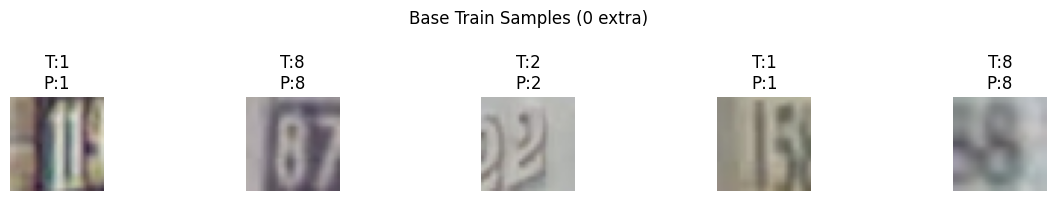

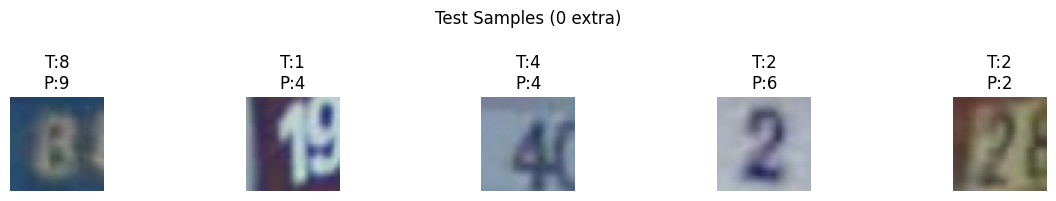

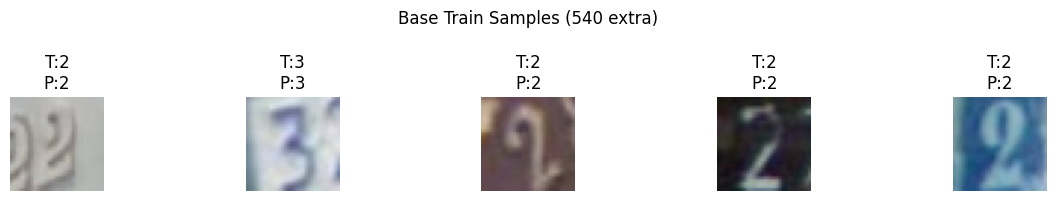

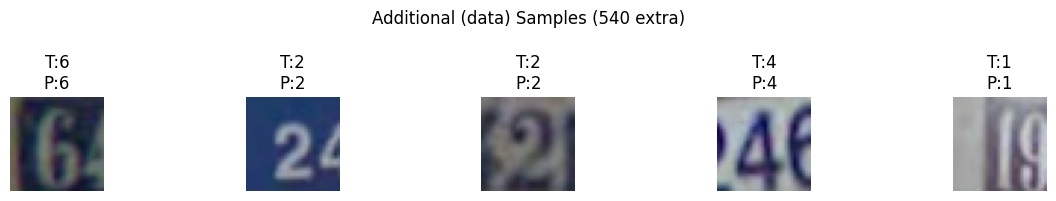

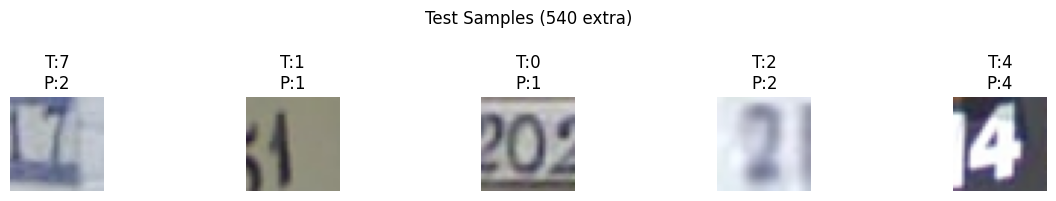

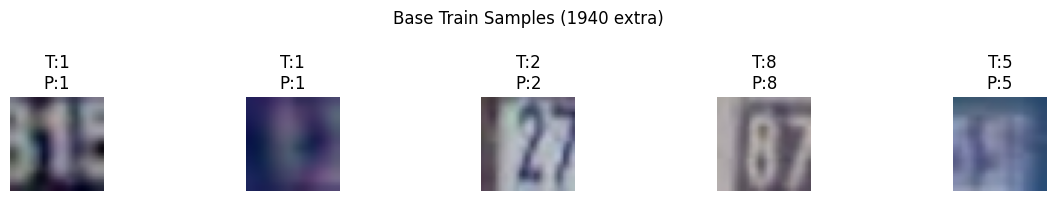

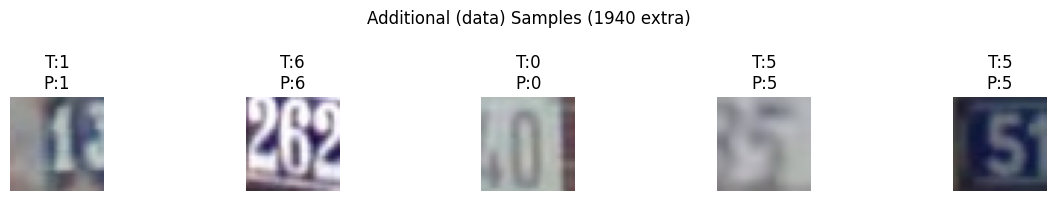

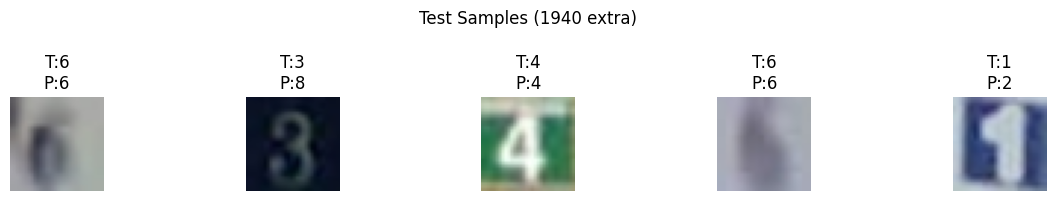

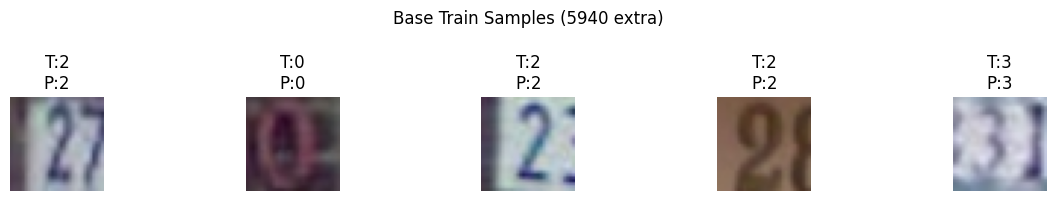

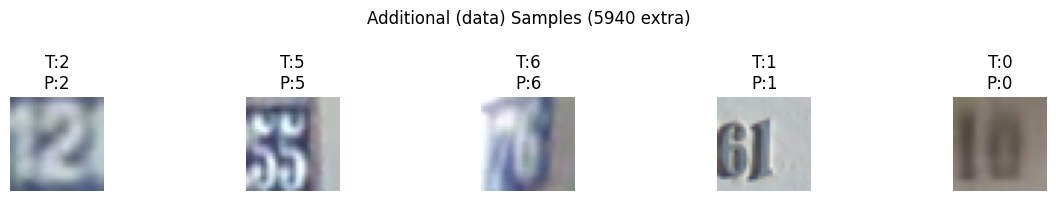

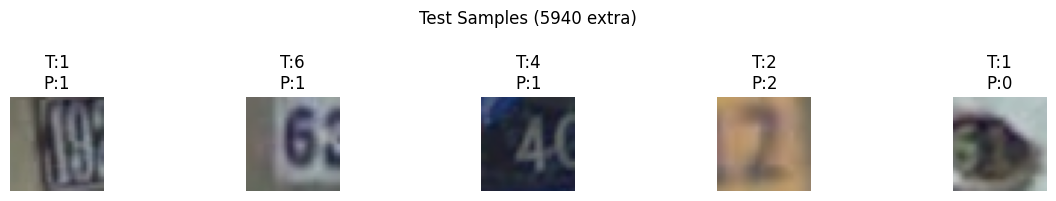

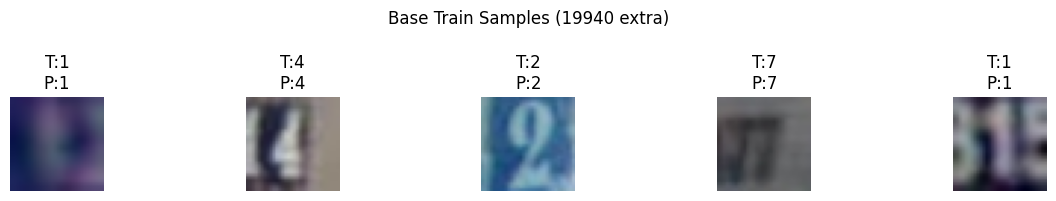

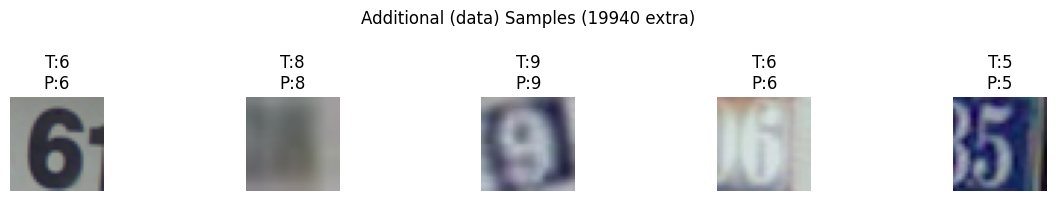

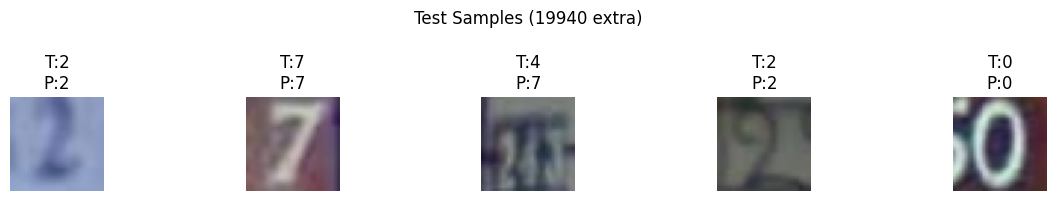

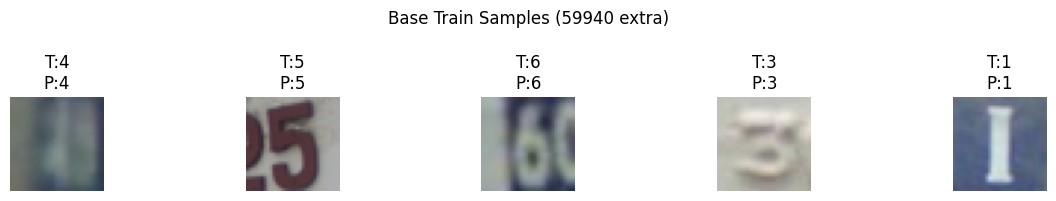

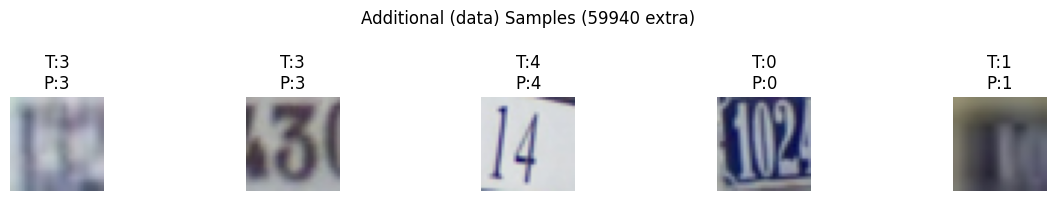

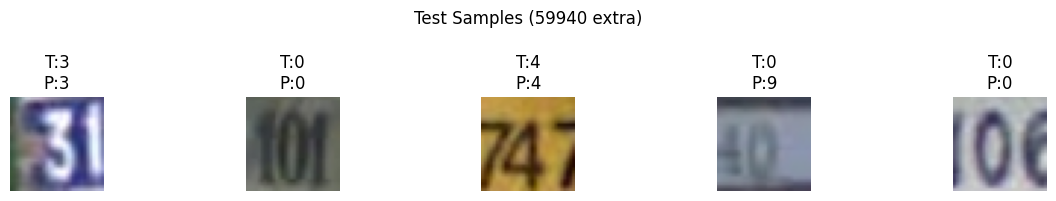

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
